In [1]:
import juliacall
import pymatgen

from pymatgen.analysis.local_env import CrystalNN
from pymatgen.core import Lattice, Structure
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter

from tqdm.notebook import tqdm
import os, os.path
import tempfile
import warnings

print("Using pymatgen version:", pymatgen.core.__version__)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Using pymatgen version: 2024.6.10


In [2]:
jl = juliacall.newmodule("NotebookModule")
jl.seval("using CrystalNets")
jl.CrystalNets.toggle_export(False)

print("Using Julia version:", jl.seval("VERSION"))
print("Running from directory:", jl.seval("Sys.BINDIR"))

Using Julia version: 1.10.3
Running from directory: /opt/julia-1.10.3/bin


In [3]:
crystallnn = CrystalNN()
crystalnets_options = jl.CrystalNets.Options(structure=jl.StructureType.Auto, clusterings=[jl.Clustering.AllNodes], bonding=jl.Bonding.Input)


def make_labels_unique(struct):
    from collections import Counter
    
    labels = Counter(site.label for site in struct.sites)
    counter = {}
    for i, site in enumerate(struct.sites):
        label = site.label
        if labels[label] > 1 or label.isalpha():
            c = counter.get(label, 0)
            site.label = f"{label}{c}" if label.isalpha() else f"{label}_{c}"
            c = c + 1
            counter[label] = c


def jimage_to_site_symmetry(jimage):
    i, j, k = jimage
    return f"1_{5+i}{5+j}{5+k}"


def writeToCifFile(bonded_struct, file):
    cif_writer = CifWriter(bonded_struct.structure)
    cif = str(cif_writer)
    cif += """loop_
_geom_bond_atom_site_label_1
_geom_bond_atom_site_label_2
_geom_bond_distance
_geom_bond_site_symmetry_2
"""

    for n, site in enumerate(bonded_struct.structure.sites):
        for connected in bonded_struct.get_connected_sites(n):
            # Make sure we only output each bond once
            if site.label < connected.site.label:
                cif += f"{site.label} {connected.site.label} {connected.dist:.6f} {jimage_to_site_symmetry(connected.jimage)}\n"

    file.write(cif.encode())


def analyse_topology(struct):
    # All labels should be unique (otherwise bond specifications will fail)
    labels = [site.label for site in struct.sites]
    if len(labels) != len(set(labels)):
        raise ValueError("labels are not unique in structure")

    bonded_struct = None
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            bonded_struct = crystallnn.get_bonded_structure(struct)
        except:
            pass

    with tempfile.NamedTemporaryFile(suffix=".cif", delete=False) as f:
        writeToCifFile(bonded_struct, f)
        f.close()
        res = jl.determine_topology(f.name, crystalnets_options)
        os.unlink(f.name)
        return [(mult, jl.ndims(net[jl.Clustering.AllNodes].genome), str(net[jl.Clustering.AllNodes])) for net, mult in res]

In [4]:
with open(os.path.expanduser("~/.mpapikey"), "r") as f:
    apikey = f.read().strip()

with MPRester(apikey) as mpr:
    structure = mpr.get_structure_by_material_id("mp-3934")
    make_labels_unique(structure)

    # Magnetic moments trigger a bug in CifWriter, so we remove them here
    # https://github.com/materialsproject/pymatgen/issues/3772
    if "magmom" in structure.site_properties:
        structure.remove_site_property("magmom")

    topo = analyse_topology(structure)
    print(topo)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

[(1, 3, 'lon')]


In [5]:
with MPRester(apikey) as mpr:
    mp_data = mpr.materials.summary.search(
        fields=["material_id", "formula", "formula_pretty", "nelements", "structure"]
    )
    print("Number of materials found:", len(mp_data))
    print("Database version", mpr.get_database_version())

Retrieving SummaryDoc documents:   0%|          | 0/153235 [00:00<?, ?it/s]

Number of materials found: 155361
Database version 2023.11.1


In [12]:
jl.CrystalNets.toggle_export(False)
jl.CrystalNets.toggle_warning(False)
warnings.filterwarnings('ignore')

res = []
errors = []

for mat in tqdm(mp_data):
    make_labels_unique(mat.structure)

    # Magnetic moments trigger a bug in CifWriter, so we remove them here
    # https://github.com/materialsproject/pymatgen/issues/3772
    if "magmom" in mat.structure.site_properties:
        mat.structure.remove_site_property("magmom")

    try:
        topo = analyse_topology(mat.structure)
        res.append([mat.material_id, mat.nelements, mat.formula_pretty, topo])
    except Exception as e:
        errors.append((mat.material_id, e))

print("Number of systems analyzed:", len(res))
print("Number of errors:", len(errors))

  0%|          | 0/155361 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
import json

with open("topo_data.json", "w") as file:
    json.dump(res, file)

In [33]:
from collections import Counter

interp = [len(x[3]) for x in res]
Counter(interp).most_common()

[(1, 46849),
 (2, 1682),
 (4, 177),
 (3, 47),
 (8, 17),
 (6, 16),
 (12, 13),
 (10, 13),
 (11, 10),
 (9, 9),
 (7, 8),
 (14, 7),
 (15, 7),
 (5, 6),
 (13, 5),
 (17, 4),
 (16, 3),
 (20, 3),
 (19, 2),
 (18, 1),
 (21, 1),
 (25, 1),
 (22, 1),
 (29, 1)]

In [48]:
dim = [y[1] for x in res for y in x[3]]
Counter(dim).most_common()

[(3, 40143), (2, 5569), (0, 4241), (1, 2501)]

In [55]:
nets = [y[2] for x in res for y in x[3]]
Counter(nets).most_common(30)

[('non-periodic', 4190),
 ('UNKNOWN 1 1 1 1', 1811),
 ('kgd', 1646),
 ('pcu', 1067),
 ('sql', 631),
 ('bcu', 612),
 ('hcb', 563),
 ('fcu', 531),
 ('xal', 385),
 ('UNKNOWN 3 1 2 0 0 0 1 2 0 0 1 1 2 1 0 0 1 2 1 0 1 1 2 1 1 0 1 2 1 1 1 1 3 0 0 0 1 3 0 0 1 1 3 0 1 0 1 3 0 1 1 1 3 1 1 0 1 3 1 1 1 2 3 -1 0 0 2 3 0 0 0 2 3 0 1 0',
  378),
 ('dia', 363),
 ('UNKNOWN 3 1 1 0 0 1 1 1 1 -1 -1 1 1 1 0 -1 1 2 -2 1 2 1 2 -2 1 3 1 2 -1 0 1 1 2 -1 0 2 1 2 -1 1 1 1 2 -1 1 2 1 2 0 0 0 1 2 0 0 1 2 2 0 0 1 2 2 0 1 0 2 2 1 -1 -2 2 2 1 -1 -1 2 2 1 -1 0 2 2 1 0 -2 2 2 1 0 -1 2 2 1 0 0 2 2 2 -1 -2',
  318),
 ('UNKNOWN 3 1 1 0 1 1 1 1 1 0 1 1 2 0 0 0 1 2 0 1 1 1 2 1 0 1 1 2 1 1 2 1 3 0 0 0 1 3 0 1 1 1 3 1 0 1 1 3 1 1 2 1 4 0 0 0 1 4 0 0 1 2 2 0 1 1 2 2 1 0 1 2 3 -1 0 -2 2 3 -1 0 -1 2 3 0 -1 -2 2 3 0 -1 -1 2 3 0 0 -1 2 3 0 0 0 2 4 -1 -1 -2 2 4 -1 0 -1 2 4 0 -1 -1 2 4 0 0 0 3 3 0 1 1 3 3 1 0 1 3 4 -1 -1 -1 3 4 -1 0 0 3 4 0 -1 0 3 4 0 0 1 4 4 0 1 1 4 4 1 0 1',
  284),
 ('UNKNOWN 3 1 2 0 0 0 1 2 1 0 1 1 3 0 0 0 1 4

In [73]:
unknown_1111 = [str(x[0]) for x in res for y in x[3] if y[2] == 'UNKNOWN 1 1 1 1']
len(unknown_1111)

1811

In [75]:
unknown_1111[:10]

['mp-732005',
 'mp-732005',
 'mp-732005',
 'mp-732005',
 'mp-695941',
 'mp-695941',
 'mp-649756',
 'mp-649756',
 'mp-703539',
 'mp-703539']

In [79]:
s = "UNKNOWN 3 1 2 0 0 0 1 2 0 0 1 1 2 1 0 0 1 2 1 0 1 1 2 1 1 0 1 2 1 1 1 1 3 0 0 0 1 3 0 0 1 1 3 0 1 0 1 3 0 1 1 1 3 1 1 0 1 3 1 1 1 2 3 -1 0 0 2 3 0 0 0 2 3 0 1 0"
unknown_2nd = [str(x[0]) for x in res for y in x[3] if y[2] == s]
len(unknown_2nd)

378

In [80]:
unknown_2nd[:20]

['mp-12062',
 'mp-944',
 'mp-7359',
 'mp-1205318',
 'mp-9899',
 'mp-1205316',
 'mp-13272',
 'mp-1077361',
 'mp-9744',
 'mp-30363',
 'mp-11816',
 'mp-9898',
 'mp-31145',
 'mp-16254',
 'mp-11700',
 'mp-1219',
 'mp-1102026',
 'mp-10616',
 'mp-10615',
 'mp-13277']

In [105]:
def write_cif_with_bonds(mpid):
    with MPRester(apikey) as mpr:
        struct = mpr.get_structure_by_material_id(mpid)

    # Magnetic moments trigger a bug in CifWriter, so we remove them here
    # https://github.com/materialsproject/pymatgen/issues/3772
    if "magmom" in struct.site_properties:
        struct.remove_site_property("magmom")

    make_labels_unique(struct)

    bonded_struct = None
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bonded_struct = crystallnn.get_bonded_structure(struct)

    for n, site in enumerate(bonded_struct.structure.sites):
        cs = bonded_struct.get_connected_sites(n)
        cl = [connected.site.label for connected in cs]
        print(f"{site.label}: coordination {len(cs)} = {' '.join(cl)}")

    with tempfile.NamedTemporaryFile(suffix=".cif", delete=False) as f:
        writeToCifFile(bonded_struct, f)
        f.close()
        print(f.name)

In [106]:
write_cif_with_bonds("mp-1219")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Ba0: coordination 12 = Ga1 Ga0 Ga0 Ga1 Ga0 Ga0 Ga1 Ga1 Ga1 Ga0 Ga1 Ga0
Ga0: coordination 9 = Ga1 Ga1 Ga1 Ba0 Ba0 Ba0 Ba0 Ba0 Ba0
Ga1: coordination 9 = Ga0 Ga0 Ga0 Ba0 Ba0 Ba0 Ba0 Ba0 Ba0
/var/folders/h8/9hx_fyj91053ksgdzb2w03vw0000gp/T/tmpn0x9vyc1.cif


In [97]:
s = "UNKNOWN 3 1 1 0 0 1 1 1 1 -1 -1 1 1 1 0 -1 1 2 -2 1 2 1 2 -2 1 3 1 2 -1 0 1 1 2 -1 0 2 1 2 -1 1 1 1 2 -1 1 2 1 2 0 0 0 1 2 0 0 1 2 2 0 0 1 2 2 0 1 0 2 2 1 -1 -2 2 2 1 -1 -1 2 2 1 -1 0 2 2 1 0 -2 2 2 1 0 -1 2 2 1 0 0 2 2 2 -1 -2"
unknown_3rd = [str(x[0]) for x in res for y in x[3] if y[2] == s]
len(unknown_3rd)

318

In [98]:
unknown_3rd[:20]

['mp-23438',
 'mp-545783',
 'mp-5663',
 'mp-19035',
 'mp-1079686',
 'mp-1105900',
 'mp-5660',
 'mp-20477',
 'mp-19245',
 'mp-19322',
 'mp-3020',
 'mp-555635',
 'mp-22571',
 'mp-8558',
 'mp-781625',
 'mp-8557',
 'mp-20991',
 'mp-21280',
 'mp-22230',
 'mp-22751']

In [107]:
write_cif_with_bonds("mp-5663")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Ba0: coordination 12 = O2 O2 O0 O1 O0 O0 O2 O2 O1 O1 O0 O1
Ce0: coordination 6 = O1 O1 O2 O0 O0 O2
O0: coordination 6 = Ce0 Ce0 Ba0 Ba0 Ba0 Ba0
O1: coordination 6 = Ce0 Ce0 Ba0 Ba0 Ba0 Ba0
O2: coordination 6 = Ce0 Ce0 Ba0 Ba0 Ba0 Ba0
/var/folders/h8/9hx_fyj91053ksgdzb2w03vw0000gp/T/tmp4aoc4mqn.cif


In [122]:
nets = [y[2] for x in res for y in x[3]]
print("Number of UNKNOWN:", sum(1 for net in nets if "UNKNOWN" in net))
print("Number of unstable:", sum(1 for net in nets if "unstable" in net))

known_nets = [net for net in nets if "UNKNOWN" not in net and "unstable" not in net]
Counter(known_nets).most_common(30)

Number of UNKNOWN: 35799
Number of unstable: 1461


[('non-periodic', 4190),
 ('kgd', 1646),
 ('pcu', 1067),
 ('sql', 631),
 ('bcu', 612),
 ('hcb', 563),
 ('fcu', 531),
 ('xal', 385),
 ('dia', 363),
 ('xbo', 249),
 ('reo-d', 193),
 ('ftw', 183),
 ('mgc-x', 172),
 ('nia', 171),
 ('flu', 161),
 ('sqc1279', 152),
 ('hxl', 109),
 ('hcp', 101),
 ('wzz', 101),
 ('spl', 94),
 ('lon', 92),
 ('bct', 91),
 ('rtl', 89),
 ('kpc', 87),
 ('tph', 87),
 ('seh', 84),
 ('acs', 80),
 ('mgz-x', 78),
 ('cco', 68),
 ('nin', 62)]

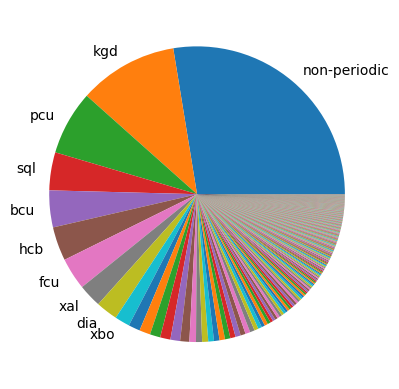

In [146]:
import matplotlib.pyplot as plt

counts = Counter(known_nets)
_ = plt.pie([float(v) for _, v in counts.most_common()], labels=[k if v > 200 else '' for k, v in counts.most_common()], autopct=None)

In [149]:
print("Number of nets found:", len(nets))
print("Number of unique nets:", len(set(nets)))

Number of nets found: 52454
Number of unique nets: 15533
